# Dimensionality Reduction

**Reference**: Maleakhi Agung Wijaya  

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error as mae
import os
from pathlib2 import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from tqdm.notebook import tqdm

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks

In [54]:
%run Utilities.ipynb

In [55]:
sns.set_context("notebook")
sns.set_style("ticks")

## Load data and preprocessing

In this step, we will load all required dataframes, fill missing values, and scale so that each column of all features are on the same scale.

In [56]:
market_orders, n_markets, aggregated_datasets = load_aggregated_datasets([DATASET_DJI, 
                                                                          DATASET_NASDAQ, 
                                                                          DATASET_NYSE,
                                                                          DATASET_RUSSELL, 
                                                                          DATASET_SP ,
                                                                          DATASET_AAPL,
                                                                          DATASET_MSFT,
                                                                          DATASET_AMZN])

## AAPL
aapl_df = aggregated_datasets["AAPL"]

## AMZN
amzn_df = aggregated_datasets["AMZN"]

## MSFT
msft_df = aggregated_datasets["MSFT"]

In [57]:
# Fill missing values, do some scaling (run prev cell first)
list_df = []

list_stock_df = []

columns_pca = [
    "Open", "Close", "Adj Close", "Lower_bb",
    "Sma", "Macd" 
]

for df in [aapl_df, msft_df, amzn_df]:
    columns = columns_pca
    df.fillna(0, inplace=True) # fill na with 0
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X[columns_pca]))
    X.columns = columns
    X["MOVEMENT"] = np.array(y)
    
    list_stock_df.append(X)


aapl_df_full = list_stock_df[0]
msft_df_full = list_stock_df[1]
amzn_df_full = list_stock_df[2]

## PCA

In this section, we will perform PCA analysis on all datasets.

### 2D scatter plot

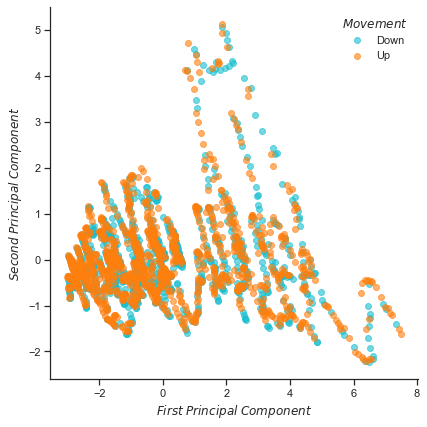

In [58]:
## DJI
y_dji_full = aapl_df_full["MOVEMENT"].values
X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"]).values

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_dji_full)
pca_data = np.vstack((pca_result.T, y_dji_full.flatten())).T
pca_df = pd.DataFrame(data=pca_data, columns=["First Principal Component", "Second Principal Component", "Movement"])

# Plot PCA
g = sns.lmplot(x="First Principal Component", y="Second Principal Component", data=pca_df, 
           fit_reg=False, legend=False, size=6, hue="Movement", palette=["C9", "C1"], scatter_kws={'alpha':0.6})
leg = plt.legend(title="$Movement$", labels=["Down", "Up"])
plt.xlabel("$First$ $Principal$ $Component$")
plt.ylabel("$Second$ $Principal$ $Component$")
leg.get_frame().set_linewidth(0.0)
plt.show()

In [59]:
# ## DJI (TI only)
# y_dji_full = aapl_df_full["MOVEMENT"].values
# X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"])
# cols_ti = list(X_dji_full.columns)[24:49]
# X_dji_full = X_dji_full[cols_ti].values

# # PCA
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(X_dji_full)
# pca_data = np.vstack((pca_result.T, y_dji_full.flatten())).T
# pca_df = pd.DataFrame(data=pca_data, columns=["First Principal Component", "Second Principal Component", "Movement"])

# # Plot PCA
# g = sns.lmplot(x="First Principal Component", y="Second Principal Component", data=pca_df, 
#            fit_reg=False, legend=False, size=6, hue="Movement", palette=["C9", "C1"], scatter_kws={'alpha':0.6})
# # leg = plt.legend(title="$Movement$", labels=["Down", "Up"])
# plt.xlabel("$First$ $Principal$ $Component$")
# plt.ylabel("$Second$ $Principal$ $Component$")
# # leg.get_frame().set_linewidth(0.0)
# plt.show()

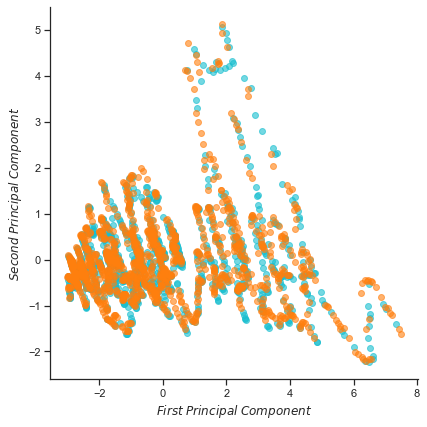

In [60]:
## (high correlation to close)
y_dji_full = aapl_df_full["MOVEMENT"].values
X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"])
cols = [
    "Open", "Close", "Adj Close", "Lower_bb",
    "Sma", "Macd"
]

X_dji_full = X_dji_full[cols].values

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_dji_full)
pca_data = np.vstack((pca_result.T, y_dji_full.flatten())).T
pca_df = pd.DataFrame(data=pca_data, columns=["First Principal Component", "Second Principal Component", "Movement"])

# Plot PCA
g = sns.lmplot(x="First Principal Component", y="Second Principal Component", data=pca_df, 
           fit_reg=False, legend=False, size=6, hue="Movement", palette=["C9", "C1"], scatter_kws={'alpha':0.6})
# leg = plt.legend(title="$Movement$", labels=["Down", "Up"])
plt.xlabel("$First$ $Principal$ $Component$")
plt.ylabel("$Second$ $Principal$ $Component$")
leg.get_frame().set_linewidth(0.0)
plt.show()

In [62]:
# ## (RFE Feature)
# y_dji_full = aapl_df_full["MOVEMENT"].values
# X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"])
# cols = [
#     "Volume", "Silver", "Nat_Gas", "Bzf",
#     "Mom20", "Slow_d", "Fast_d", "Mfi", "Macd_sig",
#     "Apo"
# ]
# X_dji_full = X_dji_full[cols].values

# # PCA
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(X_dji_full)
# pca_data = np.vstack((pca_result.T, y_dji_full.flatten())).T
# pca_df = pd.DataFrame(data=pca_data, columns=["First Principal Component", "Second Principal Component", "Movement"])

# # Plot PCA
# g = sns.lmplot(x="First Principal Component", y="Second Principal Component", data=pca_df, 
#            fit_reg=False, legend=False, size=6, hue="Movement", palette=["C9", "C1"], scatter_kws={'alpha':0.6})
# # leg = plt.legend(title="$Movement$", labels=["Down", "Up"])
# plt.xlabel("$First$ $Principal$ $Component$")
# plt.ylabel("$Second$ $Principal$ $Component$")
# leg.get_frame().set_linewidth(0.0)
# plt.show()

### Scree plot

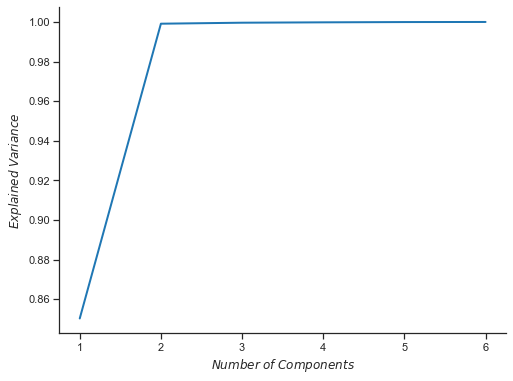

In [65]:
## DJI
y_dji_full = aapl_df_full["MOVEMENT"].values
X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"]).values

# PCA
pca = PCA()
pca_result = pca.fit_transform(X_dji_full)

fig = plt.figure(figsize=(8,6))
ax = plt.subplot2grid((1,1), (0,0))
sns.lineplot(x=np.arange(1, 7), y=pca.explained_variance_ratio_.cumsum(), lw=2, ax=ax)
sns.despine(top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("$Explained$ $Variance$")
plt.xlabel("$Number$ $of$ $Components$")
plt.show()

In [66]:
pca.explained_variance_ratio_.cumsum()

array([0.85031951, 0.99912495, 0.99962576, 0.99981446, 0.99995028,
       1.        ])

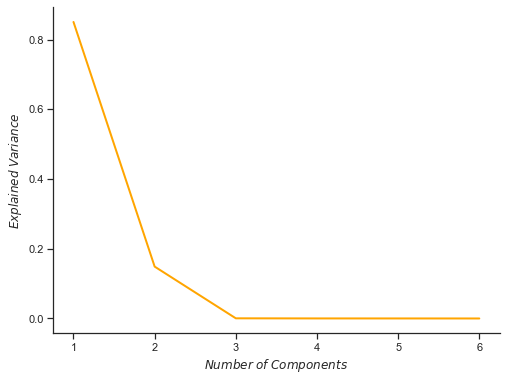

In [69]:
## DJI
y_dji_full = aapl_df_full["MOVEMENT"].values
X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"]).values

# PCA
pca = PCA()
pca_result = pca.fit_transform(X_dji_full)

fig = plt.figure(figsize=(8,6))
ax = plt.subplot2grid((1,1), (0,0))
sns.lineplot(x=np.arange(1, 7), y=pca.explained_variance_ratio_, lw=2, ax=ax, color="orange")
sns.despine(top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("$Explained$ $Variance$")
plt.xlabel("$Number$ $of$ $Components$")
plt.show()

### Components

In [ ]:
## DJI
y_dji_full = aapl_df_full["MOVEMENT"].values
X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"]).values

# PCA
pca = PCA()
pca_result = pca.fit_transform(X_dji_full)

In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = aapl_df_full.drop(columns=["MOVEMENT"]).columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [ ]:
df.head()

,0,1
0,PC0,Sp500
1,PC1,Cmo
2,PC2,Macd_sig
3,PC3,Feeder-F
4,PC4,Tnx


## t-SNE
In this section, we will perform t-SNE analysis on all datasets.

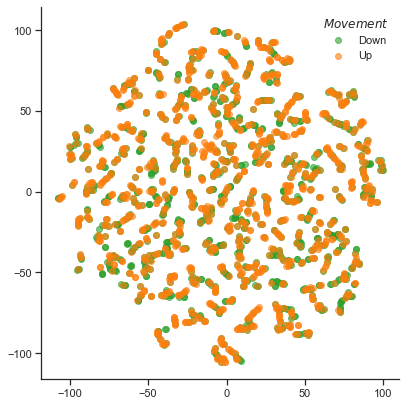

In [ ]:
## DJI
y_dji_full = aapl_df_full["MOVEMENT"].values
X_dji_full = aapl_df_full.drop(columns=["MOVEMENT"]).values

# t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=5)
tsne_results = tsne.fit_transform(X_dji_full)
tsne_data = np.vstack((tsne_results.T, y_dji_full.flatten())).T
tsne_df = pd.DataFrame(data=tsne_data, columns=["First Principal Component", "Second Principal Component", "Movement"])

# Plot tsne
g = sns.lmplot(x="First Principal Component", y="Second Principal Component", data=tsne_df, 
           fit_reg=False, legend=False, size=6, hue="Movement", palette=["C2", "C1"], scatter_kws={'alpha':0.6})
leg = plt.legend(title="$Movement$", labels=["Down", "Up"])
plt.xlabel("")
plt.ylabel("")
leg.get_frame().set_linewidth(0.0)
# plt.title(f"Perplexity = 5")
plt.show()

In [ ]:
# Plot t-SNE with respect to perplexities
perplexities = [5, 15, 25, 35, 45, 50]
tsne_results_dict = {}
# Calculate tsne results
for perplexity in perplexities:
    tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X_dji_full)
    tsne_results_dict[perplexity] = tsne_results

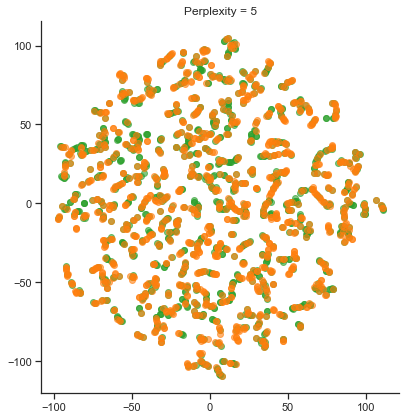

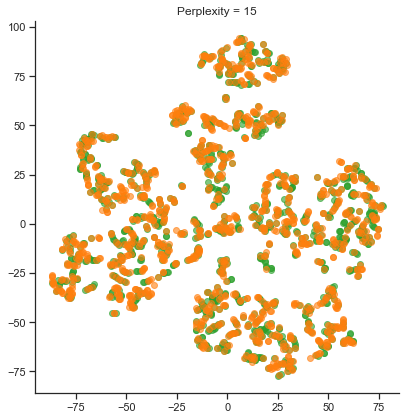

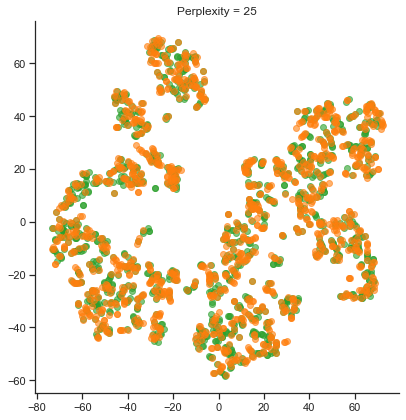

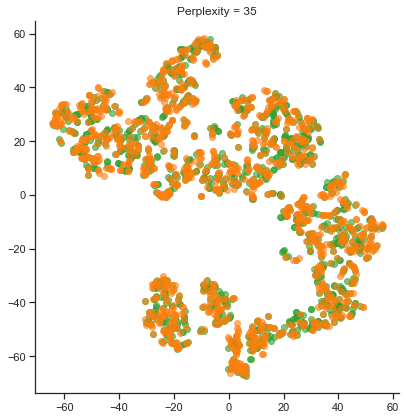

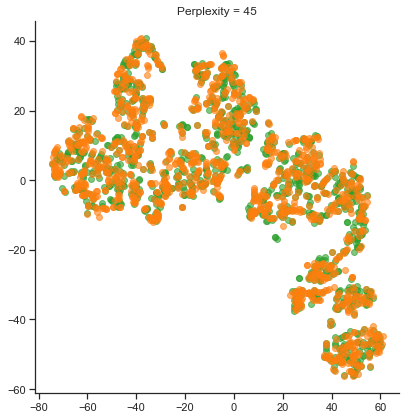

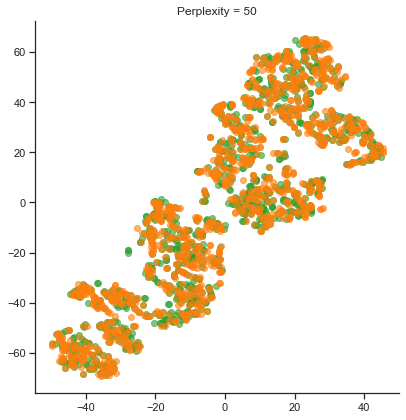

In [ ]:
# Plot tsne results    
for perp in perplexities:
    # t-SNE
    tsne_results = tsne_results_dict[perp]
    tsne_data = np.vstack((tsne_results.T, y_dji_full.flatten())).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=["First Principal Component", "Second Principal Component", "Movement"])

    # Plot tsne
    g = sns.lmplot(x="First Principal Component", y="Second Principal Component", data=tsne_df, 
           fit_reg=False, legend=False, size=6, hue="Movement", palette=["C2", "C1"], scatter_kws={'alpha':0.6})
#     leg = plt.legend(title="$Movement$", labels=["Down", "Up"])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(f"Perplexity = {perp}")
    leg.get_frame().set_linewidth(0.0)
    plt.show()
    print("\n")